Dans ce notebook, je vais utiliser la librarie fastai de Jeremy Howard afin de construire un classifieur de 130 races de chiens
120 races proviennent du dataset pris sur Kaggle, et 10 autres ont été rajoutées:
- labradoodle,
- dalmatien,
- berger belge,
- berger australien,
- shih tzu,
- dogue argentin,
- american bully,
- jack russell,
- cane corso et akita.
Les images des 10 dernières classes ont été scrapées grâce à l'extension Fatkun sur Google Chrome

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Si entrainement fait sur le cloud car GPU gratuit et plus grosse RAM, entrer les 3 premieres installations !pip

!pip install -Uqq fastbook
!pip install fastai --upgrade -q
!pip install efficientnet-pytorch

# Cacher les messages d'alerte
import warnings  
warnings.filterwarnings('ignore')


# Import des librairies et des metrics
from fastai.vision.all import *
from fastai.learner import Learner
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import error_rate, accuracy
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet


     |████████████████████████████████| 719 kB 31.8 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 5.5 MB 63.4 MB/s 
     |████████████████████████████████| 451 kB 65.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.4 MB/s 
     |████████████████████████████████| 182 kB 74.7 MB/s 
     |████████████████████████████████| 115 kB 73.4 MB/s 
     |████████████████████████████████| 212 kB 16.5 MB/s 
     |████████████████████████████████| 127 kB 3.2 MB/s 
     |████████████████████████████████| 7.6 MB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f852afe2a8cbb5ea19dd37d744b95ecb42522cb20fc742b3d52f2aa27a9fca16
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorc

In [3]:
# Path pour acceder au dataset
dataset_path = Path('/content/drive/MyDrive/races').absolute()
fns = get_image_files(dataset_path)
fns

(#21820) [Path('/content/drive/MyDrive/races/vizsla/vizsla_127.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_116.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_131.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_2.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_126.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_8.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_36.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_83.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_115.jpg'),Path('/content/drive/MyDrive/races/vizsla/vizsla_119.jpg')...]

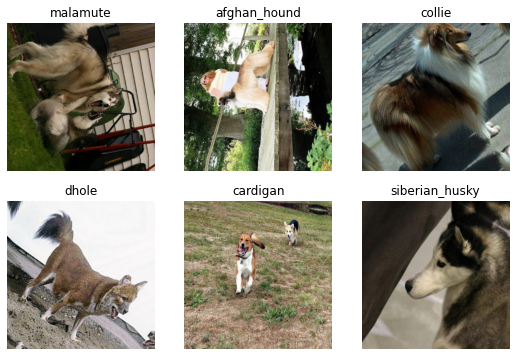

In [4]:
# Creation du train set (80%), test set (20%) et  transformations (rotation jusqu'a 90°), normalization

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512, method='squish'),
    batch_tfms=[*aug_transforms(size=260, max_rotate=90.0),
                               Normalize.from_stats(*imagenet_stats)])


data = dblock.dataloaders(dataset_path, bs=52) 

# Visualisation d'images
data.show_batch(max_n=6)                       

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


SuggestedLRs(valley=0.0003981071640737355)

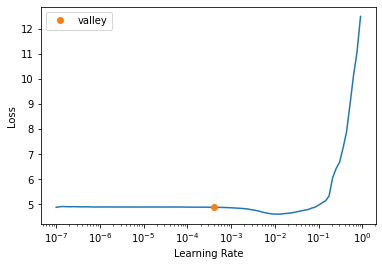

In [5]:
# Selection du model B2 de EfficientNet pour le transfer learning
model_name = 'efficientnet-b2'
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model

learn = Learner(data, get_model(), 
                metrics=[ accuracy, error_rate])
learn.lr_find()


In [6]:
# Entrainement sur 15 epoch, Callback afin d'arreter l'entrainement au bout de 5 epoch si aucune ameliortation (+ 1%) de notre metrique valid_loss

learn.fine_tune(15, freeze_epochs=1, base_lr=1e-4, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5),SaveModelCallback(monitor='valid_loss', min_delta=0.01)])


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.642203,2.402581,0.595784,0.404216,1:43:57


Better model found at epoch 0 with valid_loss value: 2.402580976486206.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.652364,2.231525,0.680797,0.319203,05:32
1,2.101028,1.680468,0.741751,0.258249,05:29
2,1.556630,1.148316,0.792392,0.207608,05:32
3,1.156721,0.808965,0.823556,0.176444,05:31
4,0.929808,0.659615,0.839368,0.160632,05:34
5,0.794205,0.576965,0.845784,0.154216,05:32
6,0.709552,0.532119,0.849908,0.150092,05:37
7,0.628340,0.500778,0.855179,0.144821,05:35
8,0.578708,0.489828,0.860907,0.139093,05:39
9,0.552634,0.476341,0.862053,0.137947,05:33


Better model found at epoch 0 with valid_loss value: 2.231525182723999.
Better model found at epoch 1 with valid_loss value: 1.680468201637268.
Better model found at epoch 2 with valid_loss value: 1.1483163833618164.
Better model found at epoch 3 with valid_loss value: 0.8089649081230164.
Better model found at epoch 4 with valid_loss value: 0.6596146821975708.
Better model found at epoch 5 with valid_loss value: 0.5769653916358948.
Better model found at epoch 6 with valid_loss value: 0.5321194529533386.
Better model found at epoch 7 with valid_loss value: 0.5007778406143188.
Better model found at epoch 8 with valid_loss value: 0.48982828855514526.
Better model found at epoch 9 with valid_loss value: 0.47634074091911316.
Better model found at epoch 10 with valid_loss value: 0.46273577213287354.


Nous obtenons donc un modele avec un taux d'erreur de 13% pour la reconnaissance de 130 races de chien

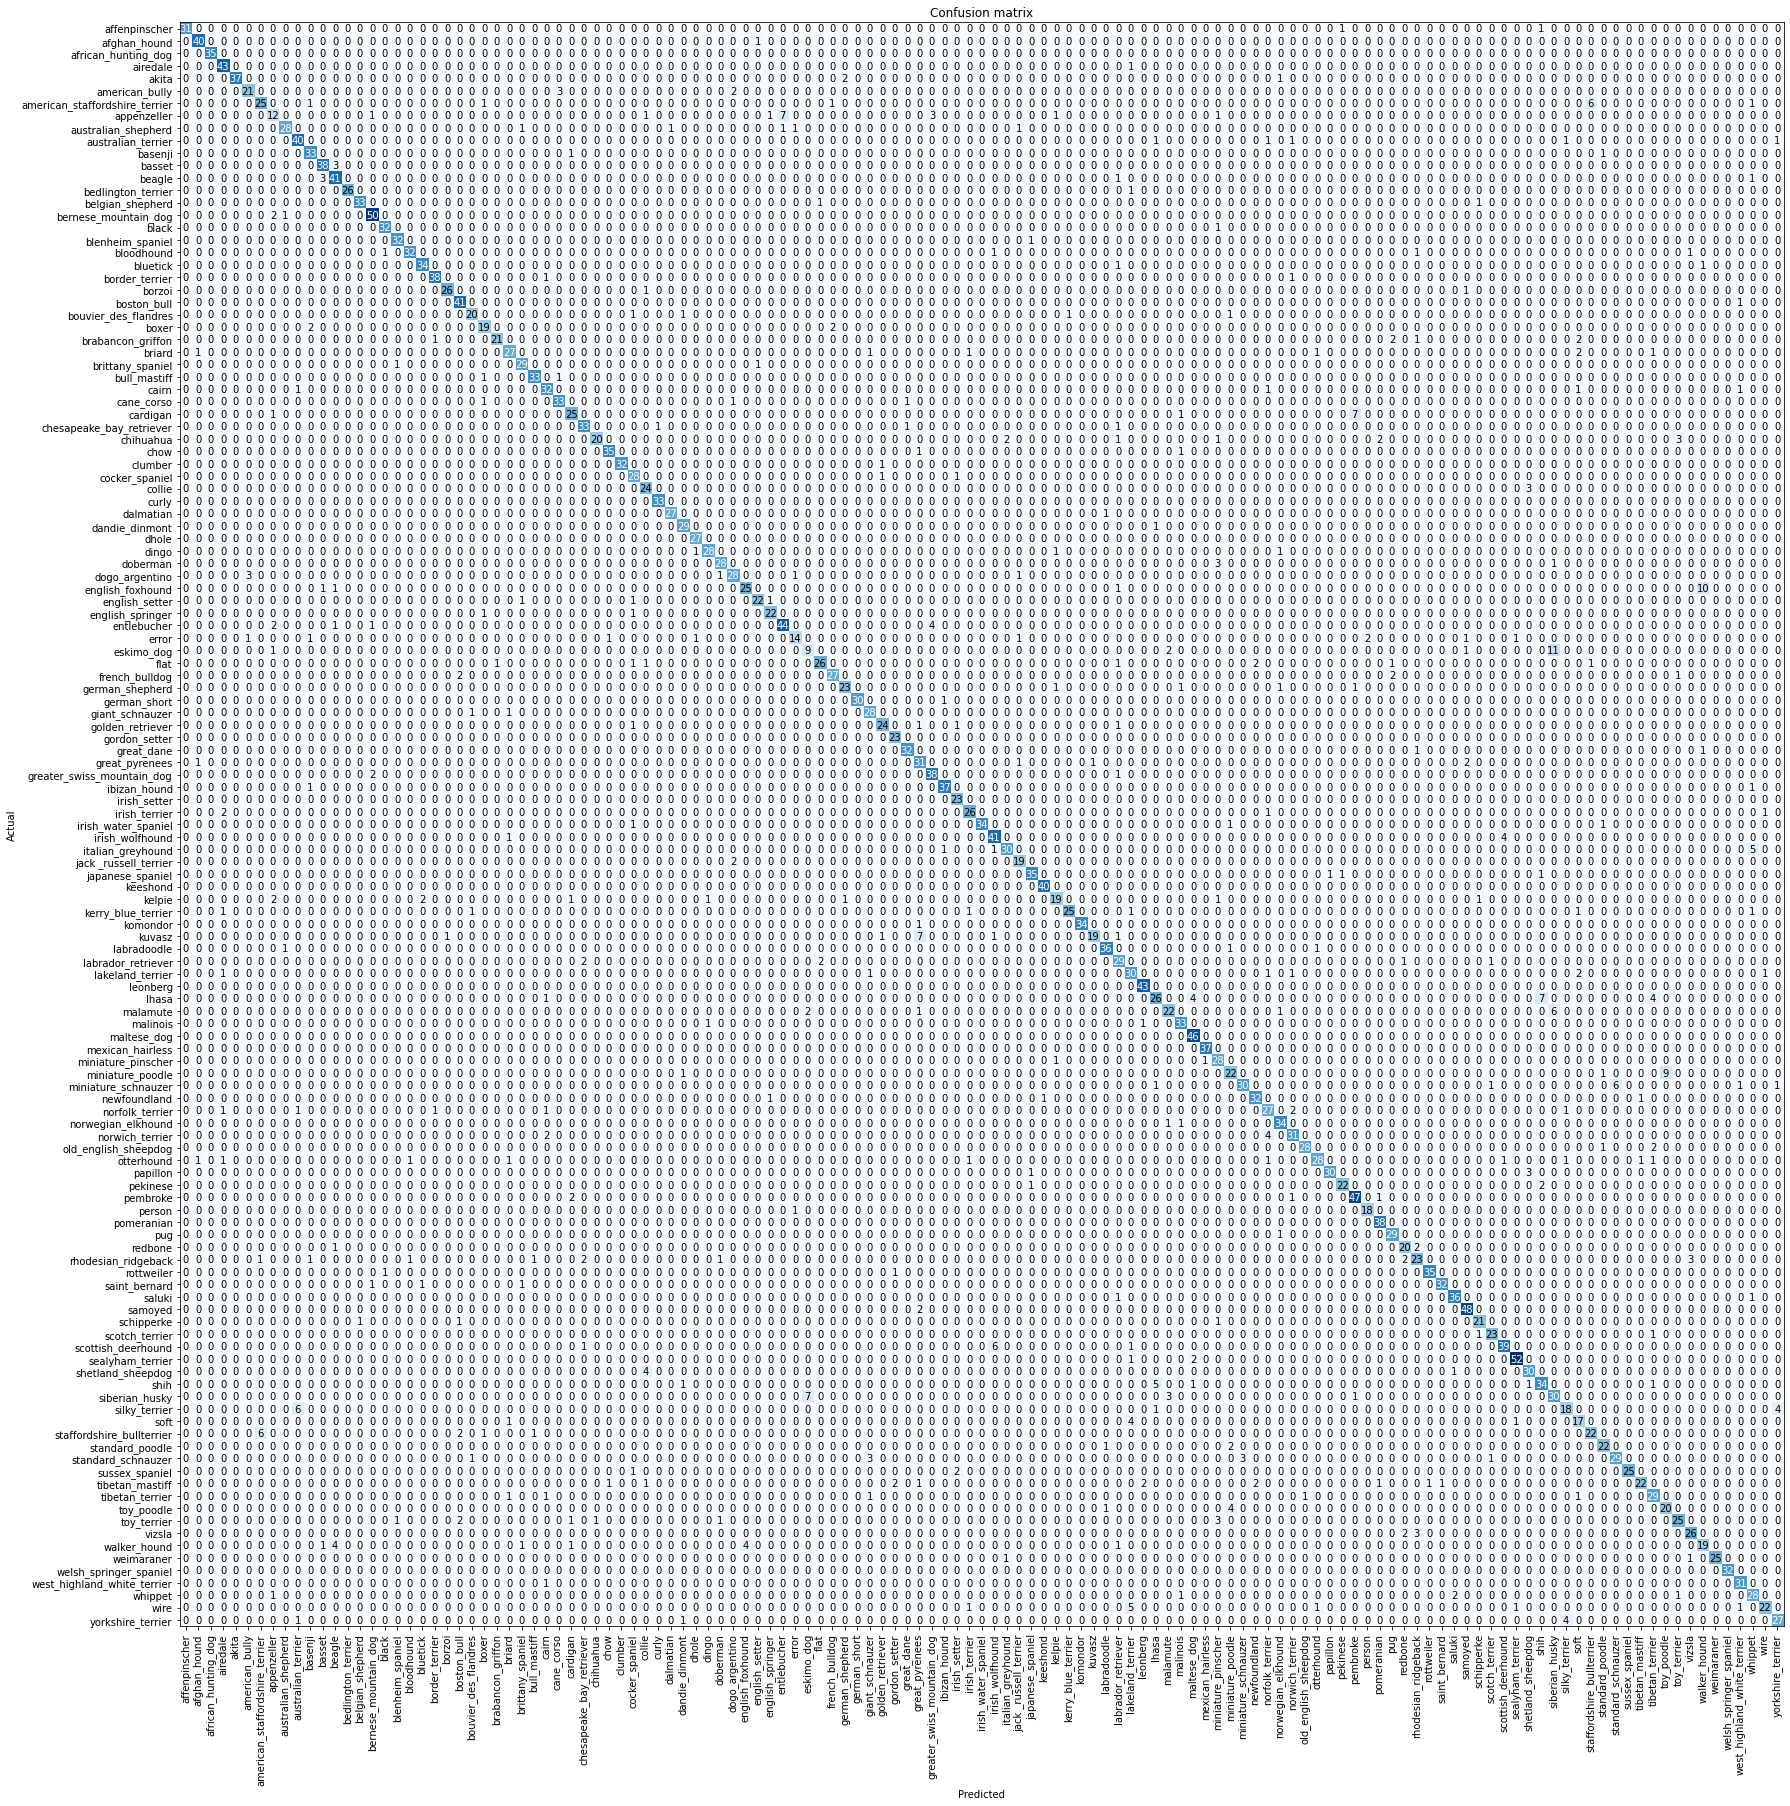

In [13]:
# Matrice de confusion
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(25,25))

In [8]:
# Categories ou il y a eu au moins 3 confusions
interp.most_confused(min_val=3)

[('eskimo_dog', 'siberian_husky', 11),
 ('english_foxhound', 'walker_hound', 10),
 ('miniature_poodle', 'toy_poodle', 9),
 ('appenzeller', 'entlebucher', 7),
 ('cardigan', 'pembroke', 7),
 ('kuvasz', 'great_pyrenees', 7),
 ('lhasa', 'shih', 7),
 ('siberian_husky', 'eskimo_dog', 7),
 ('american_staffordshire_terrier', 'staffordshire_bullterrier', 6),
 ('malamute', 'siberian_husky', 6),
 ('miniature_schnauzer', 'standard_schnauzer', 6),
 ('scottish_deerhound', 'irish_wolfhound', 6),
 ('silky_terrier', 'australian_terrier', 6),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 6),
 ('italian_greyhound', 'whippet', 5),
 ('shih', 'lhasa', 5),
 ('wire', 'lakeland_terrier', 5),
 ('entlebucher', 'greater_swiss_mountain_dog', 4),
 ('irish_wolfhound', 'scottish_deerhound', 4),
 ('lhasa', 'maltese_dog', 4),
 ('lhasa', 'tibetan_terrier', 4),
 ('norwich_terrier', 'norfolk_terrier', 4),
 ('shetland_sheepdog', 'collie', 4),
 ('silky_terrier', 'yorkshire_terrier', 4),
 ('soft', 'lakelan

In [9]:
# Report de classification des categories
interp.print_classification_report()

                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.94      0.97        33
                  afghan_hound       0.93      0.98      0.95        41
           african_hunting_dog       1.00      1.00      1.00        35
                      airedale       0.88      0.98      0.92        44
                         akita       1.00      0.93      0.96        40
                american_bully       0.84      0.81      0.82        26
american_staffordshire_terrier       0.78      0.71      0.75        35
                   appenzeller       0.57      0.44      0.50        27
           australian_shepherd       0.93      0.85      0.89        33
            australian_terrier       0.82      0.89      0.85        45
                       basenji       0.85      0.94      0.89        35
                        basset       0.88      0.93      0.90        41
                        beagle       0.80      0.89      0.85  

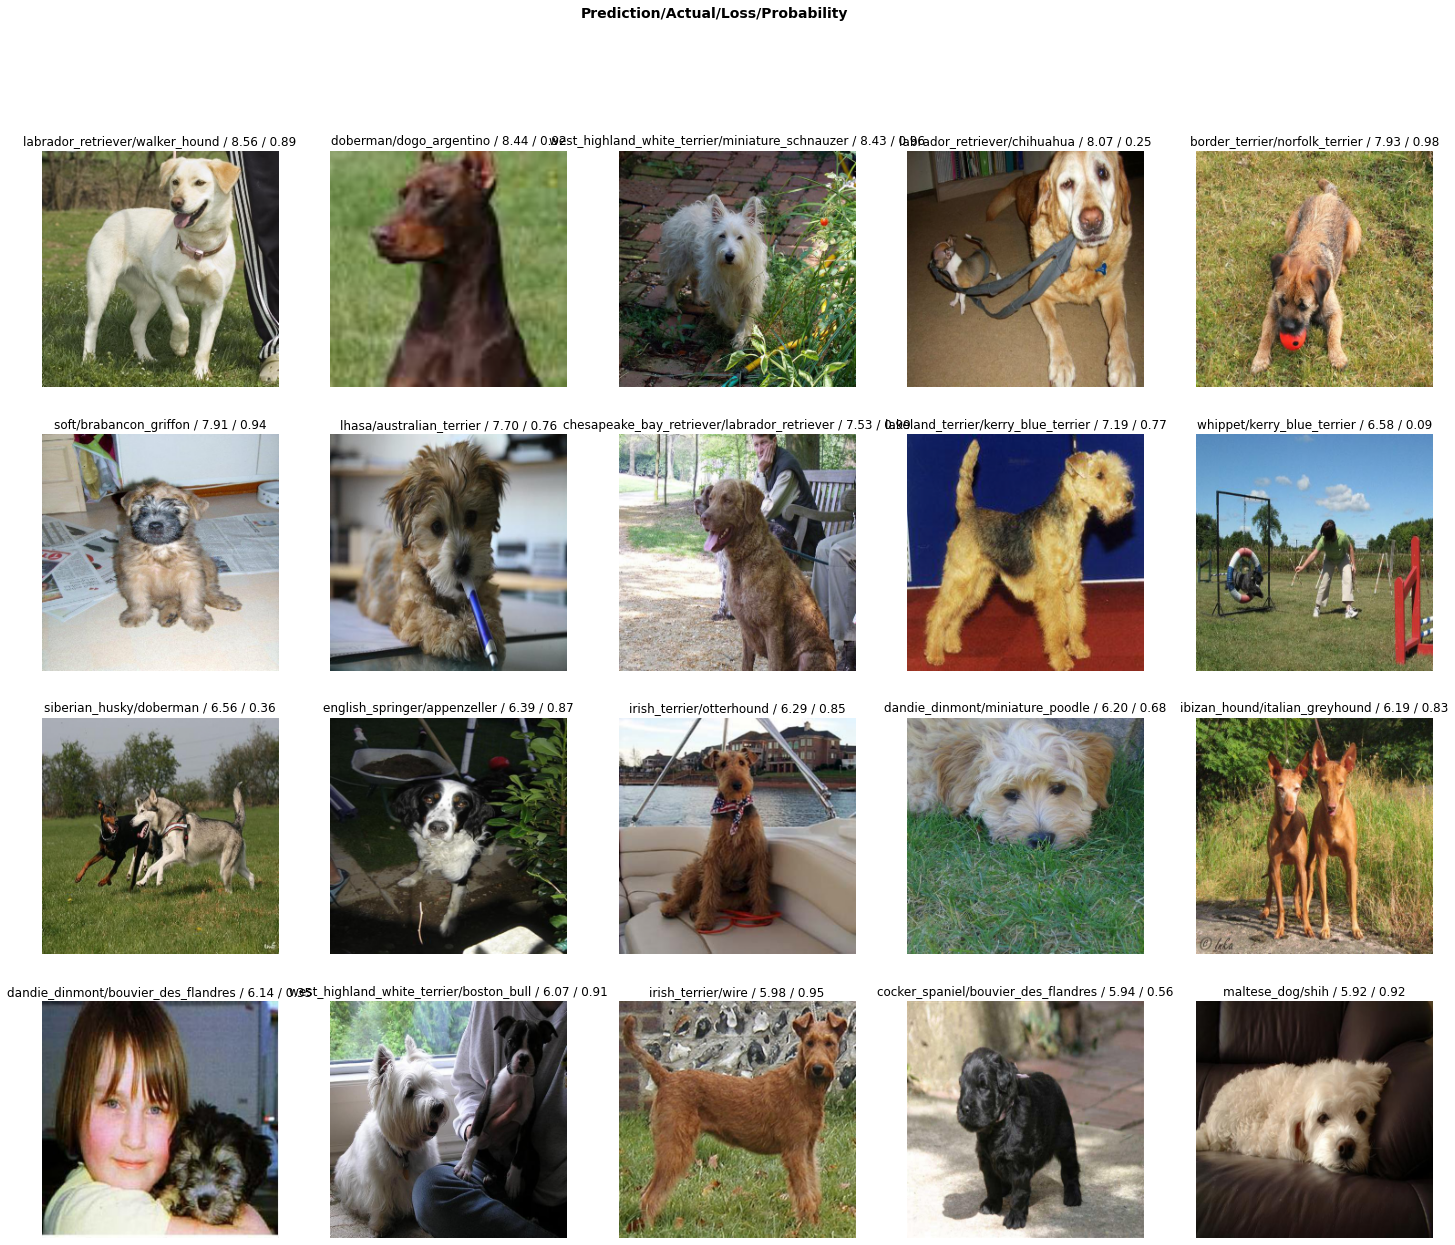

In [10]:
# Affichage des images ayant induit en erreur le modele:
interp.plot_top_losses(20, figsize=(25,20))

# Exemple:
# Pour la premiere image, le modele est a 89% sur qu'il s'agit d'un labrador bien que l'image soit classee dans walker_hound.
# Ceci peut nous aider a remarquer des mauvaises classifications des le depart. Ainsi en reclassifiant les images dans les bonnes classes, un nouvel entrainement ameliorait les resultats


In [11]:
# Verification des metriques du modele sur le test set, respectivement: loss, accuracy et error_rate (1 - accuracy)
learn.validate()

(#3) [0.46273577213287354,0.8677818775177002,0.132218137383461]

In [12]:
# Sauvegarde du modele
learn.export("dogbreeds_b2_87.pkl")

In [ ]:
# Telechargement du modele
from google.colab import files
files.download('dogbreeds_b2_87.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>